5000: loss 0.039 time 48.18


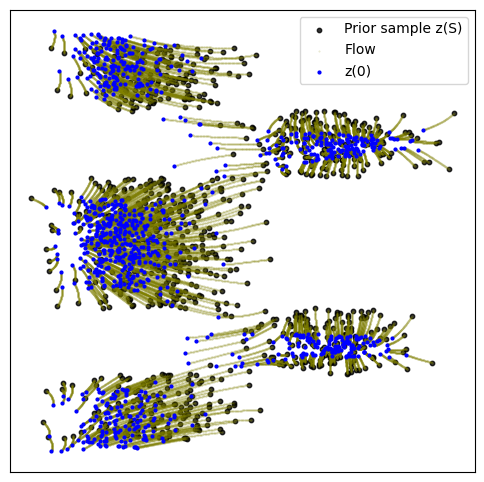

10000: loss 0.037 time 51.33


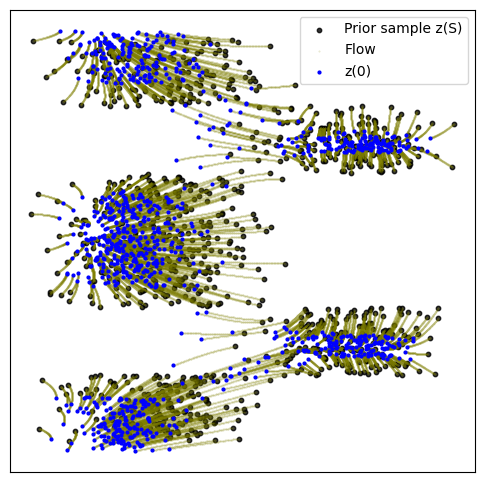

KeyboardInterrupt: 

In [1]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

# Data generation for your example
def sample_conditional_data(batch_size):
    # Generate y uniformly
    y = np.random.uniform(-0.5, 2.5, batch_size)
    x = np.zeros_like(y)

    # Generate x based on y
    for i in range(len(x)):
        if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
            x[i] = np.random.normal(1, scale=0.5)
        else:
            x[i] = np.random.normal(-1, scale=0.5)
    
    # Convert to torch tensors
    x_torch = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
    y_torch = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    return x_torch, y_torch


def sample_gaussian_data(batch_size):
    # Generate y uniformly
    
    x = np.random.normal(0,1, batch_size)
    x_torch = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
    
    return x_torch 

# Parameters
sigma = 0.1
dim = 2  # (x, y) as a 2D input
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    # Sample data
    x1, y1 = sample_conditional_data(batch_size)  # Another batch for transition
    y0  = y1
    x0 = sample_gaussian_data(batch_size)  # Conditional data
    # Combine x and y for both time points
    z0 = torch.cat([x0, y0], dim=-1)
    z1 = torch.cat([x1, y1], dim=-1)

    # Sample locations and conditional flows
    t, xt, ut = FM.sample_location_and_conditional_flow(z0, z1)

    # Predict flow using the model
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print progress and visualize
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                torch.cat(sample_conditional_data(1024), dim=-1),  # Sample trajectories
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())


Other example

In [2]:
def sample_conditional_data(batch_size):
    # Generate y uniformly
    y = np.random.uniform(-0.5, 2.5, batch_size) 
    X = y.reshape(-1, 1)
    xtrue = np.zeros_like(y)

    # Apply conditions to generate xtrue based on y
    for i in range(len(xtrue)):
        if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
            xtrue[i] = 0
        else:
            xtrue[i] = np.random.normal(0, scale=0.5 + 1 * abs(np.sin(np.pi * y[i])))

# Generate x and s
        x = xtrue + np.random.normal(0, 1, len(xtrue))
        
    x_torch = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
    y_torch = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    return x_torch, y_torch

5000: loss 0.042 time 61.90


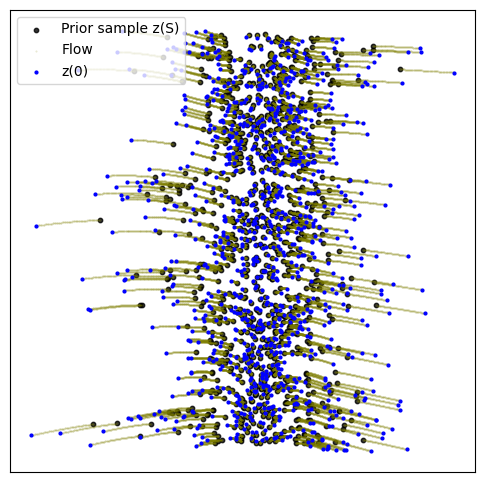

10000: loss 0.058 time 64.82


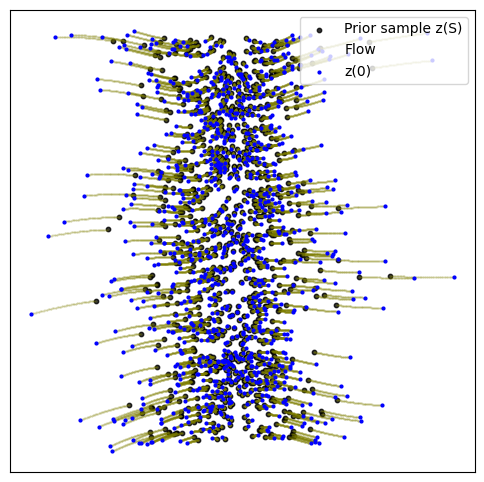

15000: loss 0.030 time 73.18


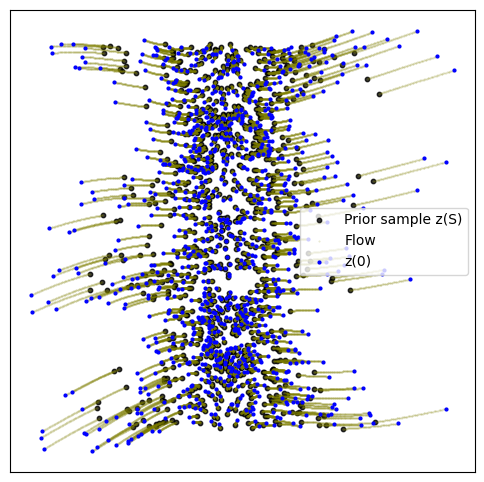

20000: loss 0.034 time 73.72


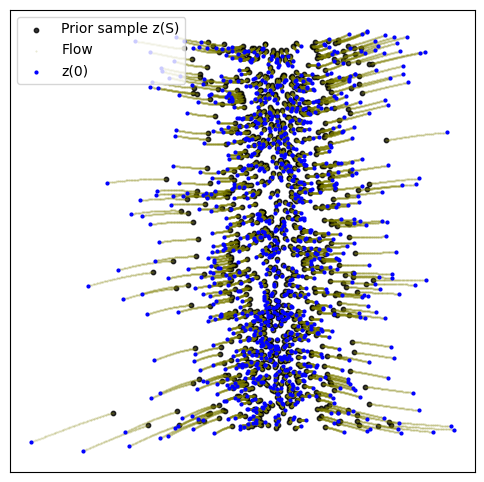

In [3]:
# Parameters
sigma = 0.1
dim = 2  # (x, y) as a 2D input
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    # Sample data
    x1, y1 = sample_conditional_data(batch_size)  # Another batch for transition
    y0  = y1
    x0 = sample_gaussian_data(batch_size)  # Conditional data
    # Combine x and y for both time points
    z0 = torch.cat([x0, y0], dim=-1)
    z1 = torch.cat([x1, y1], dim=-1)

    # Sample locations and conditional flows
    t, xt, ut = FM.sample_location_and_conditional_flow(z0, z1)

    # Predict flow using the model
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print progress and visualize
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                torch.cat(sample_conditional_data(1024), dim=-1),  # Sample trajectories
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())


In [ ]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchdyn
from torchdyn.core import NeuralODE
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *


# Data generation for your example
def sample_conditional_data(batch_size):
    # Generate y uniformly
    y = np.random.uniform(-0.5, 2.5, batch_size)
    x = np.zeros_like(y)

    # Generate x based on y
    for i in range(len(x)):
        if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
            x[i] = np.random.normal(1, scale=0.5)
        else:
            x[i] = np.random.normal(-1, scale=0.5)

    # Convert to torch tensors
    x_torch = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
    y_torch = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    return x_torch, y_torch


def sample_gaussian_data(batch_size):
    # Generate standard Gaussian data
    x = np.random.normal(0, 1, batch_size)
    x_torch = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
    return x_torch


# Train the flow model
def train_flow_model(batch_size, epochs=20000, sigma=0.1, dim=2):
    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

    start = time.time()
    for k in range(epochs):
        optimizer.zero_grad()

        # Sample data
        x1, y1 = sample_conditional_data(batch_size)  # Another batch for transition
        y0 = y1  # Maintain consistent conditioning
        x0 = sample_gaussian_data(batch_size)  # Conditional data

        # Combine x and y for both time points
        z0 = torch.cat([x0, y0], dim=-1)
        z1 = torch.cat([x1, y1], dim=-1)

        # Sample locations and conditional flows
        t, xt, ut = FM.sample_location_and_conditional_flow(z0, z1)

        # Predict flow using the model
        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Print progress
        if (k + 1) % 5000 == 0:
            end = time.time()
            print(f"Epoch {k+1}/{epochs}: Loss {loss.item():0.3f}, Time {(end - start):0.2f} s")
            start = end

    return model, FM


# Compute posterior mean
def compute_posterior_mean(model, x, y, FM, sigma=1.0, num_samples=1024):
    with torch.no_grad():
        posterior_means = []

        for i in range(len(x)):
            # Sample locations for xtrue using flow model
            y_tensor = torch.tensor([[y[i]]], dtype=torch.float32).repeat(num_samples, 1)
            x_tensor = torch.tensor([x[i]], dtype=torch.float32).repeat(num_samples, 1)
            z = torch.cat([x_tensor, y_tensor], dim=-1)

            # NeuralODE trajectory prediction
            t_span = torch.linspace(0, 1, 100)
            traj = FM.sample_location_and_conditional_flow(z, z)[0]

            # Posterior mean
            posterior_mean = traj.mean().item()
            posterior_means.append(posterior_mean)

    return np.array(posterior_means)


# Main script
batch_size = 256
epochs = 20000

# Train flow model
model, FM = train_flow_model(batch_size, epochs)


Epoch 5000/20000: Loss 0.024, Time 39.15 s
Epoch 10000/20000: Loss 0.044, Time 40.84 s
Epoch 15000/20000: Loss 0.023, Time 50.37 s
Epoch 20000/20000: Loss 0.046, Time 48.81 s


In [9]:
y = np.random.uniform(-0.5, 2.5, batch_size)
x = np.zeros_like(y)

    # Generate x based on y
for i in range(len(x)):
        if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
            x[i] = np.random.normal(1, scale=0.5)
        else:
            x[i] = np.random.normal(-1, scale=0.5)

    # Convert to torch tensors
test_x = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
test_y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
 

# Compute posterior mean
posterior_means = compute_posterior_mean(model, test_x.numpy().flatten(), test_y.numpy().flatten(), FM)

# Visualization 


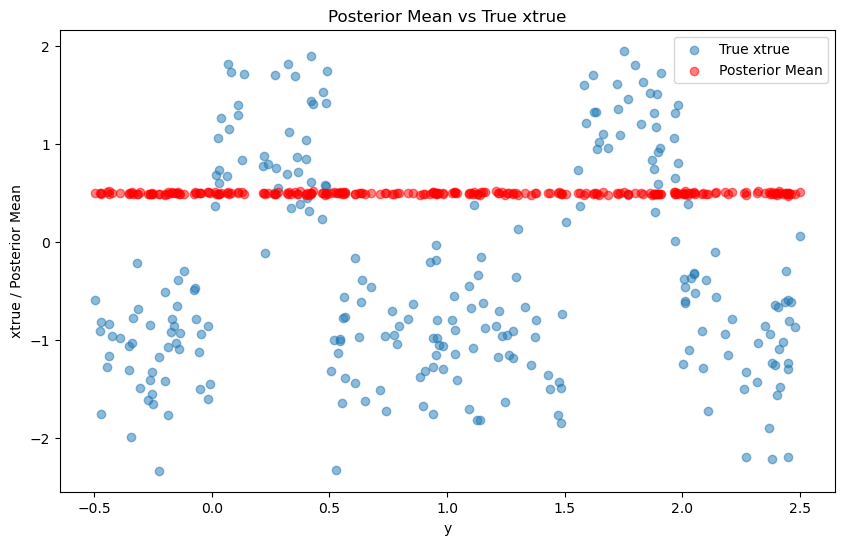

In [10]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(test_y.numpy(), test_x.numpy(), alpha=0.5, label="True xtrue")
plt.scatter(test_y.numpy(), posterior_means, alpha=0.5, label="Posterior Mean", color="red")
plt.xlabel("y")
plt.ylabel("xtrue / Posterior Mean")
plt.title("Posterior Mean vs True xtrue")
plt.legend()
plt.show()